# FASE 2: Voorspellen elektrisch verbruik warmtepomp

* kWh per tijdbasis 15m
* Household 1 gebruikt voor data (JVR)
* datetime features
   * stookseizoen
   * dag
   * uur

In [65]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import datetime as dt

from scripts import weather_data_preprocess as wdp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.ensemble import RandomForestRegressor

In [66]:
# Geef een enkele dag weer in een grafiek
def plot_day(data, day: dt.datetime):
    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot()
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    ax1.plot(data['datetime'], data['consumption_kWh'], label='Consumption (kWh)', color='g')
    ax1.set_xlabel('Hour of the day')
    ax1.set_ylabel('Energy (kWh)', color='black')
    ax1.legend(loc='upper left')
    ax2.plot(data['datetime'], data['temp'], label='Temperature (°C)', color='b')
    ax2.set_ylabel('Temperature (°C)', color='black')
    ax2.legend(loc='upper right')
    plt.title(f'Energy on {day}')
    plt.grid(True)
    plt.show()

In [69]:
# Filter gegevens op een lijst met substrings
def filter_data(df, column_name, substrings):
    return df[df[column_name].str.contains('|'.join(substrings))]

## Data-analyse
### Inlezen en voorbereiden van data

In [70]:
# Open de datasets
df_heat = pd.read_csv('data/raw/household_1_heat_pump_consumption_warmtepomp from 2024-03-01.csv')
df_heat.head()

,_time,heat_consumption
0,2024-03-14 08:00:00+01:00,8017.324
1,2024-03-14 08:15:00+01:00,8017.365
2,2024-03-14 08:45:00+01:00,8017.488
3,2024-03-14 09:00:00+01:00,8017.525
4,2024-03-14 09:15:00+01:00,8017.561


In [71]:
# Kolommen hernoemen
df_heat.rename(columns={'_time': 'datetime', 'heat_consumption': 'consumption_kWh'}, inplace=True)

In [72]:
# Tijdskolom aanpassen
df_heat['datetime'] = (df_heat['datetime'].str.replace(' ', 'T'))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+01:00', ''))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+02:00', ''))
df_heat['datetime'] = pd.to_datetime(df_heat['datetime'], errors='coerce')
print(f"Errors: {df_heat['datetime'].isnull().sum()}")
df_heat = df_heat.dropna(subset=['datetime'])
print(f"Dataset size: {df_heat.size}")
df_heat.tail()

Errors: 1
Dataset size: 57090


,datetime,consumption_kWh
28540,2025-01-17 12:45:00,9446.932
28541,2025-01-17 13:00:00,9447.173
28542,2025-01-17 13:15:00,9447.402
28543,2025-01-17 13:30:00,9447.618
28544,2025-01-17 13:45:00,9447.814


In [73]:
# Analyse van de dataset
df_heat.describe()

,datetime,consumption_kWh
count,28545,28545.000000
mean,2024-08-16 18:37:52.622175232,8534.105786
min,2024-03-14 08:00:00,8017.324000
25%,2024-06-01 09:00:00,8338.288000
50%,2024-08-14 18:15:00,8462.171000
75%,2024-11-04 05:45:00,8635.691000
max,2025-01-17 13:45:00,9447.814000
std,NaN,310.828906


In [74]:
# Ruwe weersdata info
weather_data_ingelmunster = [
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv',
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]

In [75]:
# Interpoleren van de weergegevens
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_data_ingelmunster)):
    print(f'Processing {weather_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_data_ingelmunster[file])])

Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv
Processing Ingelmunster 2024-06-01 to 2024-06-30.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_3715/1456375200.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_data_ingelmunster[file])])
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and wil

Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please

Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv


/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()
/Users/thijspirmez/Documents/Howest/Projects/2025_Proflex/proflex/proflex_ai/scripts/weather_data_preprocess.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df.resample('15T').interpolate()


In [76]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [77]:
# Datasets samenvoegen
df = pd.merge(df_heat, df_weather_ingelmunster, on='datetime', how='right')
df.head()

,datetime,consumption_kWh,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-01 00:00:00,NaN,10.00,94.100,0.0,0.0,-3.140464,-0.815327
1,2024-03-01 00:15:00,NaN,9.25,95.575,0.0,0.0,-3.045971,-0.813262
2,2024-03-01 00:30:00,NaN,8.50,97.050,0.0,0.0,-2.952222,-0.807331
3,2024-03-01 00:45:00,NaN,7.75,98.525,0.0,0.0,-2.859890,-0.797631
4,2024-03-01 01:00:00,NaN,7.00,100.000,0.0,0.0,-2.769568,-0.784312


In [78]:
df.tail()

,datetime,consumption_kWh,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
32990,2025-01-31 22:00:00,NaN,3.50,0.0,0.0,0.0,2.327568,-0.848447
32991,2025-01-31 22:15:00,NaN,3.35,5.0,0.0,0.0,2.412971,-0.877163
32992,2025-01-31 22:30:00,NaN,3.20,10.0,0.0,0.0,2.503325,-0.903172
32993,2025-01-31 22:45:00,NaN,3.05,15.0,0.0,0.0,2.598675,-0.926103
32994,2025-01-31 23:00:00,NaN,2.90,20.0,0.0,0.0,2.698852,-0.945579


In [79]:
# Ontbrekende data aanvullen met forward fill (goed voor tijdreeksen)
df = df.bfill()
df = df.ffill()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32995 entries, 0 to 32994
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         32995 non-null  datetime64[ns]
 1   consumption_kWh  32995 non-null  float64       
 2   temp             32995 non-null  float64       
 3   cloudcover       32995 non-null  float64       
 4   solarenergy      32995 non-null  float64       
 5   uvindex          32995 non-null  float64       
 6   solar_azimuth    32995 non-null  float64       
 7   solar_elevation  32995 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.0 MB


In [80]:
# kWh meterstand omrekenen naar kWh/kwartier
df['consumption_15kWh'] = (df['consumption_kWh'] - df['consumption_kWh'].shift(1))
df.drop(['consumption_kWh'], axis=1, inplace=True)
df.dropna(subset=['consumption_15kWh'], inplace=True)
df.head()

,datetime,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,consumption_15kWh
1,2024-03-01 00:15:00,9.25,95.575,0.0,0.0,-3.045971,-0.813262,0.0
2,2024-03-01 00:30:00,8.50,97.050,0.0,0.0,-2.952222,-0.807331,0.0
3,2024-03-01 00:45:00,7.75,98.525,0.0,0.0,-2.859890,-0.797631,0.0
4,2024-03-01 01:00:00,7.00,100.000,0.0,0.0,-2.769568,-0.784312,0.0
5,2024-03-01 01:15:00,6.75,100.000,0.0,0.0,-2.681729,-0.767569,0.0


In [81]:
# Eerste en laatste rijen verwijderen waar de meterstand niet klopt (0.0) doordat de meterstand niet is opgenomen
first_nonzero_idx = df[df['consumption_15kWh'] != 0.0].index[0]
last_nonzero_idx = df[df['consumption_15kWh'] != 0.0].index[-1]
df = df.loc[first_nonzero_idx:last_nonzero_idx].reset_index(drop=True)
print(f"Trimmed dataset between: {first_nonzero_idx} and {last_nonzero_idx}")

Trimmed dataset between: 1281 and 31613


In [82]:
def replace_outliers_with_mean(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = df[column].mean()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = mean_value
    return df

df = replace_outliers_with_mean(df, 'consumption_15kWh')

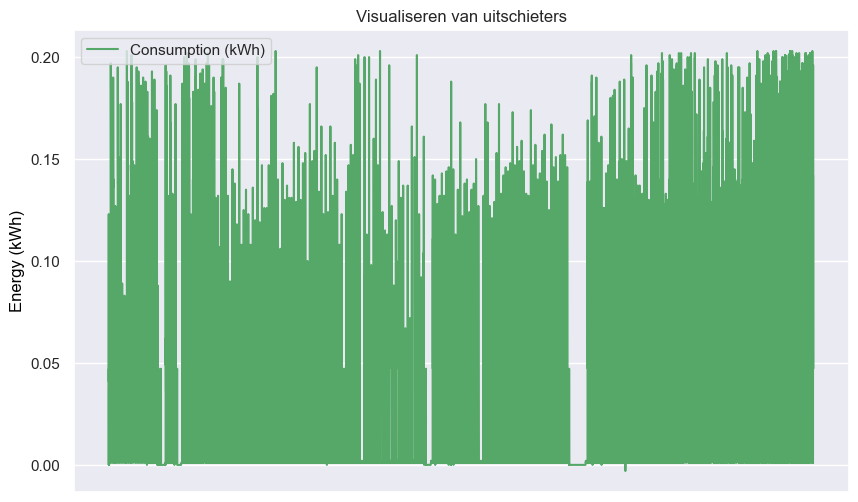

In [83]:
# Visualiseren van de uitschieters
plt.figure(figsize=(10, 6))
ax1 = plt.subplot()
plt.xticks(rotation=90)
ax1.plot(df['datetime'], df['consumption_15kWh'], label='Consumption (kWh)', color='g')
ax1.set_ylabel('Energy (kWh)', color='black')
ax1.legend(loc='upper left')
plt.xticks([])  # Removes the x-axis ticks
ax1.set_xticklabels([]) # Removes the x-axis labels
plt.title(f'Visualiseren van uitschieters')
plt.grid(True)
plt.show()

### Bewerking datetime en verwijderen van onnodige kolommen

In [84]:
# Geef de dag van het jaar, de dag van de week en de tijd van de dag weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df['day_of_year'] = df['datetime'].dt.dayofyear
# Dag van de week extraheren
df['day_of_week'] = df['datetime'].dt.dayofweek
# Uur van de dag extraheren
df['time_of_day'] = df['datetime'].dt.hour
# Bereken sinus- en cosinuswaarden voor day_of_year
df['day_of_year_sine'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cosine'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
# Bereken sinus- en cosinuswaarden voor day_of_week
df['day_of_week_sine'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cosine'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
# Bereken sinus- en cosinuswaarden voor hour_of_day
df['hour_of_day_sine'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
df['hour_of_day_cosine'] = np.cos(2 * np.pi * df['time_of_day'] / 24)

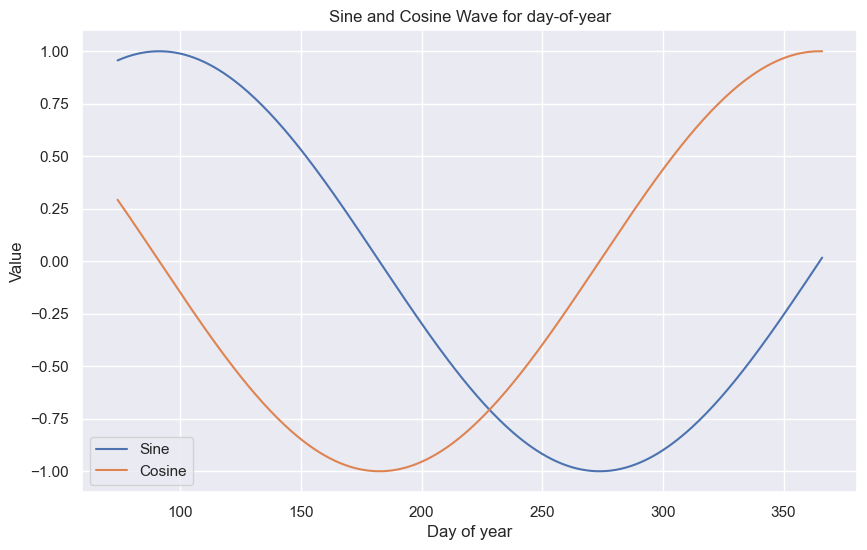

In [85]:
# day_of_year omvorming weergeven
df_single_year = df[df['datetime'].dt.year == 2024]
plt.figure(figsize=(10, 6))
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_sine'], label='Sine')
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_cosine'], label='Cosine')
plt.xlabel('Day of year')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-year')
plt.legend()
plt.grid(True)
plt.show()

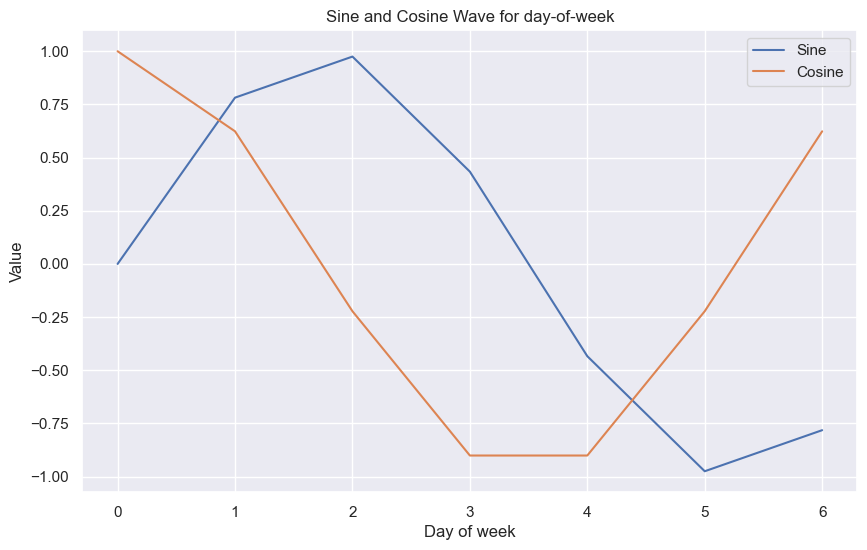

In [86]:
# day_of_week omvorming weergeven
df_single_month = df[df['datetime'].dt.day_of_year.isin([176, 177, 178, 179, 180, 181, 182])]
plt.figure(figsize=(10, 6))
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_sine'], label='Sine')
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_cosine'], label='Cosine')
plt.xlabel('Day of week')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-week')
plt.legend()
plt.grid(True)
plt.show()

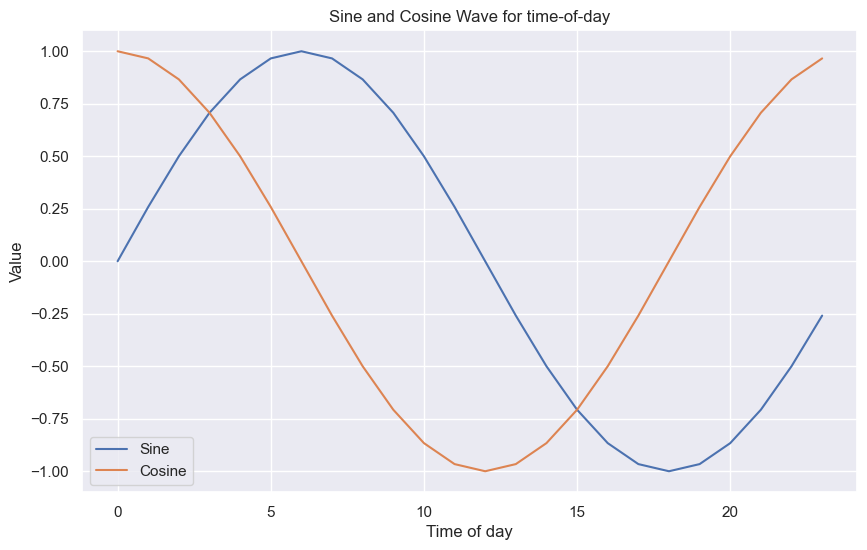

In [87]:
# hour_of_day omvorming weergeven 
df_single_day = df[df['datetime'].dt.day_of_year == 170]
plt.figure(figsize=(10, 6))
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_sine'], label='Sine')
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_cosine'], label='Cosine')
plt.xlabel('Time of day')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for time-of-day')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
# Verwijderen van overbodige kolommen
df.drop(columns=['datetime', 'day_of_year', 'day_of_week', 'time_of_day'], inplace=True)

Text(0.5, 1.0, 'Correlatiematrix')

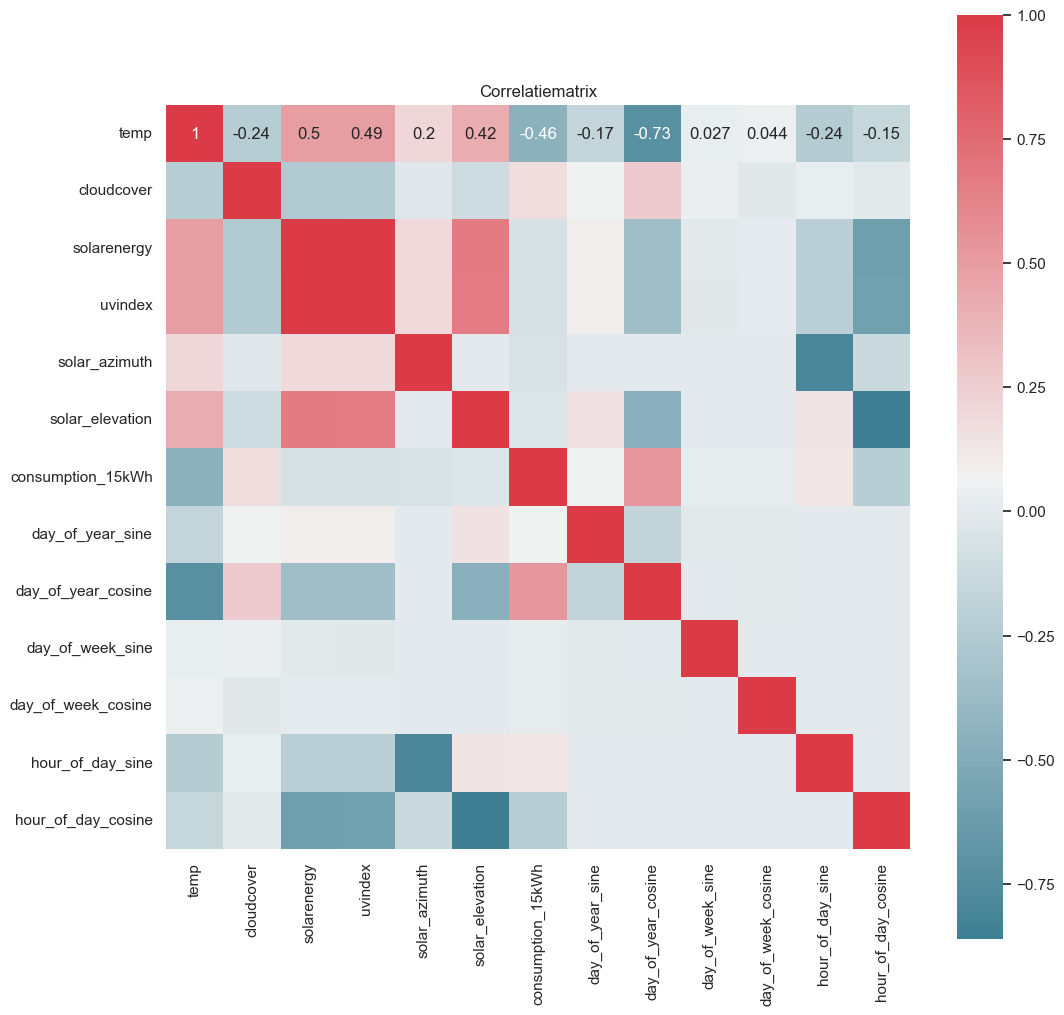

In [89]:
# Plotten van een heatmap om de correlatie tussen de features te visualiseren
f, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot=True)
plt.title("Correlatiematrix")

## Pre-processing van de data

In [90]:
# Eén maand opzij zetten als finale testset
df_test = df.tail(1000)
df = df.head(-1000)

In [91]:
# Splits de dataset in een trainings- en testset
y = df['consumption_15kWh']
X = df.drop(['consumption_15kWh'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# De gegevens schalen, aangezien we de outliers hebben verwijderd, kunnen we de MinMaxScaler gebruiken
scaler_consumption = RobustScaler()
scaler_consumption.fit(X_train)
X_train = scaler_consumption.transform(X_train)
X_test = scaler_consumption.transform(X_test)

## Training

In [93]:
# Verschillende hyperparameters uitproberen voor de Random Forest Regressor
estimators = [10, 50, 100, 150]
rf_depths = [2, 10, 20, 35, 40, 50]

In [164]:
# Trainen van elke combinatie van hyperparameters en opslaan van de resultaten van het beste model voor consumptie
best_score_consumption = 0
best_model_consumption = None
for estimator in estimators:
    for depth in rf_depths:
        rf_model = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        rf_model.fit(X_train, y_train)
        score = rf_model.score(X_test, y_test)
        if score > best_score_consumption:
            best_score_consumption = score
            best_model_consumption = rf_model
            # Save the model
            print(f"New best model found with estimators: {estimator}, depth: {depth}, and score: {score}")
            with open('models/wp_ML_2.0.pkl', 'wb') as file:
                pickle.dump(rf_model, file)

New best model found with estimators: 10, depth: 2, and score: 0.43064385094793833
New best model found with estimators: 10, depth: 10, and score: 0.815768540006508
New best model found with estimators: 10, depth: 20, and score: 0.8452685471059027
New best model found with estimators: 10, depth: 35, and score: 0.8497251623153943
New best model found with estimators: 10, depth: 40, and score: 0.8516796514842255
New best model found with estimators: 50, depth: 20, and score: 0.8640426075187553
New best model found with estimators: 100, depth: 20, and score: 0.8640966624188604
New best model found with estimators: 100, depth: 35, and score: 0.866618191114125


## Testen

In [94]:
# Beste model inladen
with open('models/wp_ML_2.0.pkl', 'rb') as file:
    best_model_consumption = pickle.load(file)

In [95]:
# Validatiegegevens voorbereiden
df_actual_value = df_test[['consumption_15kWh']]
df_test.drop(columns=['consumption_15kWh'], inplace=True)
df_actual_value.reset_index(drop=True, inplace=True)
df_actual_value.head()

,consumption_15kWh
0,0.186
1,0.190
2,0.195
3,0.198
4,0.197


In [96]:
# Voorspellingen doen
df_consumption_pred = best_model_consumption.predict(scaler_consumption.transform(df_test))

In [97]:
# Scoor de model op basis van de validatiegegevens
score_consumption = best_model_consumption.score(scaler_consumption.transform(df_test), df_actual_value['consumption_15kWh'])
print(f"Score consumption: {score_consumption}")

Score consumption: 0.10774558957495994


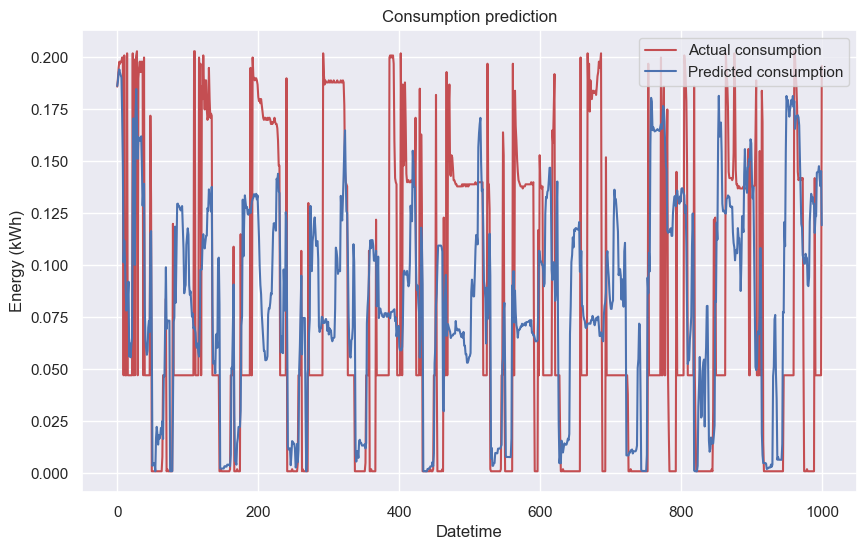

In [98]:
# Visualiseer de verbruiksvoorspellingen
plt.figure(figsize=(10, 6))
plt.plot(df_actual_value['consumption_15kWh'], label='Actual consumption', color='r')
plt.plot(df_consumption_pred, label='Predicted consumption', color='b')
plt.xlabel('Datetime')
plt.ylabel('Energy (kWh)')
plt.title('Consumption prediction')
plt.legend()
plt.grid(True)
plt.show()